In [62]:
import torch
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod

device = "cuda" if torch.cuda.is_available() else "cpu"
S0 = torch.tensor([100.0], requires_grad=True, device=device)
r = torch.tensor(0.05, requires_grad=True, device = device)
sigma = torch.tensor(0.2, requires_grad=True, device = device)
# T = torch.tensor(1.0, requires_grad=True, device = device)
K = torch.tensor(100.0, requires_grad=True, device = device)

N = 10000
M = 12
timestep = torch.tensor(1.0 / M, requires_grad=True, device = device)

Z = torch.randn(N, device=device)
path_df = pd.DataFrame(columns=["t", "name", "value"])



In [57]:
S_prev = torch.ones(N, device=device) * S0 
path_df = pd.DataFrame(columns=["t", "name", "value"])
path_dict = {}
for m in range(M):
    S = S_prev * torch.exp((r - 0.5 * sigma**2) * timestep + sigma * torch.sqrt(timestep) * Z)        
    S_val = S.detach().cpu().numpy()
    path_df = pd.concat(
        [path_df, pd.DataFrame({"t": m, "name": "S", "value": S_val})], 
        ignore_index=True)
    path_dict[(m, "S")] = S
    S_prev = S

payoffs = torch.max(K - S, torch.zeros_like(S))
price = payoffs.mean()
price.backward()

print(f"Price: {price.item():.4f}")
print(f"Delta: {S0.grad.item():.4f}")
print(f"Vega: {sigma.grad.item() :.4f}")
print(f"Theta: {T.grad.item():.4f}")

path_dict[(1, "S")]   

Price: 18.4043
Delta: -0.9032
Vega: 216.2827
Theta: 5.4497


tensor([111.5751, 120.8427,  87.4238,  ..., 102.2415, 111.0873, 107.0294],
       device='cuda:0', grad_fn=<MulBackward0>)

In [35]:
path_df.tail()

,t,name,value
119995,11,S,72.195679
119996,11,S,75.849777
119997,11,S,126.124619
119998,11,S,125.715706
119999,11,S,175.197205


# クラス

## 商品定義からパス生成まで

In [91]:
class FinancialProduct:
    """
    A plain data holder for financial product information.    
    """
    def __init__(self, product_name, payoff_fn=None, **params):
        """
        product_name: str
            e.g. 'european_call', 'knock_out_call', 'asian_call'
        params: dict
            e.g. strike, barrier, rebate, etc.
        """
        self.product_name = product_name
        self.params = params
        self.payoff_fn = payoff_fn


    def __repr__(self):
        return f"<FinancialProduct: {self.product_name}, {self.params}>"

    @staticmethod
    def create_american_put(S0: float, K: float, sigma: float, T: float, r:float) -> FinancialProduct:
        payoff_fn = lambda x: torch.max(K - x, torch.zeros_like(x))
        return FinancialProduct(
            product_name="american_put",
            payoff_fn = payoff_fn,
            K=K,
            T=T,
            S0=S0,
            sigma=sigma,
            r=r,
            is_call=False,
            is_american=True
        )    


In [143]:
class PathGenerator(ABC):

    def __init__(self, N_steps, N_paths, seed = None, use_pytorch = False):
        self.T = T
        self.N_steps = N_steps
        self.N_paths = N_paths
        self.seed = seed
        self.use_pytorch = use_pytorch
        self.path_dict = {}

    @abstractmethod
    def generate(self, fin_prod: FinancialProduct) -> None:
        pass

    def get_path(self, step: int, name: str):
        """
        Retrieve a path value by (step, name) key.
        """
        return self.path_dict.get((step, name), None) 


class GBMPathGenerator(PathGenerator):
    def __init__(self, N_steps, N_paths, seed = None, use_pytorch = True):        
        super().__init__(N_steps, N_paths, seed, use_pytorch)

    def generate(self, fin_prod: FinancialProduct) -> None:

        device = "cuda" if torch.cuda.is_available() else "cpu"
        S0 = torch.tensor(fin_prod.params["S0"], requires_grad=True, device=device)
        r = torch.tensor(fin_prod.params["r"], requires_grad=True, device = device)
        sigma = torch.tensor(fin_prod.params["sigma"], requires_grad=True, device = device)
        timestep = torch.tensor(fin_prod.params["T"] / self.N_steps, requires_grad=True, device = device)
                        
        path_df = pd.DataFrame(columns=["t", "name", "value"])

        S_prev = torch.ones(self.N_paths, device=device) * S0 
        # path_df = pd.DataFrame(columns=["t", "name", "value"])
        
        # ステップごとの S をまとめて保存
        S_cols = {}
        S_cols["step_init"] = S_prev.detach().cpu().numpy()

        for m in range(M):
            Z = torch.randn(self.N_paths, device=device)
            S = S_prev * torch.exp((r - 0.5 * sigma**2) * timestep + sigma * torch.sqrt(timestep) * Z)        
            # S_val = S.detach().cpu().numpy()
            # path_df = pd.concat(
            #     [path_df, pd.DataFrame({"t": m, "name": "S", "value": S_val})], 
            #     ignore_index=True)
            self.path_dict[(m, "S")] = S
            S_prev = S
            S_cols[f"step_{m}"] = S_prev.detach().cpu().numpy()
        
        # Pandasにまとめる
        pd.DataFrame(S_cols).plot.hist(alpha=0.5, bins=50)







In [184]:
print(M-1)
for m in reversed(range(M-1)):
    print(m)
    break

V = prod.payoff_fn(gbm_gen.get_path(M-1, "S"))
m=10
S = gbm_gen.get_path(m, "S")
P = prod.payoff_fn(S)

# s_prev      = S.detach().cpu().numpy()
# p_prev      = P.detach().cpu().numpy()
# v           = V.detach().cpu().numpy()
# tgt_s = s_numpy[p_numpy > 0]
# tgt_v = v_numpy[p_numpy > 0]
# poly = PolynomialFeatures(degree=2, include_bias=True)
# X = poly.fit_transform(tgt_s.reshape(-1, 1))
# model = LinearRegression(fit_intercept=False)
# model.fit(X, tgt_v)
# V_hat = model.predict(X)
# print(tgt_s)
# print(tgt_v[tgt_v == 0][:2])
# print(Y_hat[tgt_v == 0][:2])


tgt_S = S[P > 0]
tgt_V = V[P > 0]

X = torch.vstack([torch.ones_like(tgt_S), tgt_S, tgt_S ** 2]).T 
beta, *_ = torch.linalg.lstsq(X, tgt_V.unsqueeze(-1))

# 予測値
V_hat = (X @ beta).squeeze()

print(tgt_V[tgt_V == 0][:2])
print(V_hat[tgt_V == 0][:2])

V[P > 0] = V_hat 
V = torch.maximum(V, P)

11
10
tensor([0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([4.8761, 4.9805], device='cuda:0', grad_fn=<SliceBackward0>)


<FinancialProduct: american_put, {'K': 100.0, 'T': 1.0, 'S0': 100.0, 'sigma': 0.2, 'r': 0.05, 'is_call': False, 'is_american': True}>


ValueError: Found input variables with inconsistent numbers of samples: [10000, 4491]

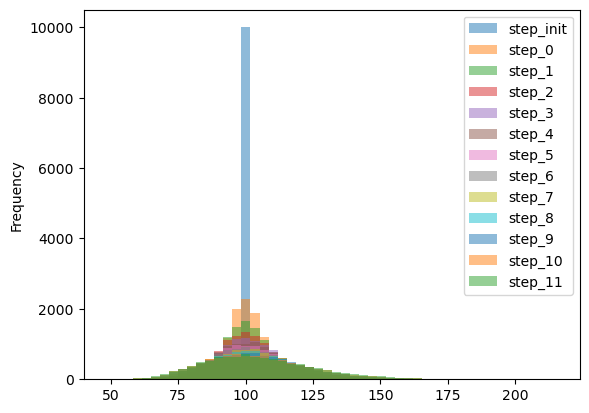

In [ ]:
prod = FinancialProduct.create_american_put(
    S0=100.0,
    K=100.0,
    T=1.0,
    r=0.05,
    sigma = 0.2
)
print(prod)

N = 10000
M = 12
gbm_gen = GBMPathGenerator(N_steps=M, N_paths=N)
gbm_gen.generate(prod)
gbm_gen.get_path(1, "S")

# V = prod.payoff_fn(gbm_gen.get_path(M-1, "S"))
# print(V)
# m=10
# X = prod.payoff_fn(gbm_gen.get_path(m, "S"))  
# V2 = torch.maximum(V, X)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


V = prod.payoff_fn(gbm_gen.get_path(M-1, "S"))
for m in reversed(range(M-1)):
    S = gbm_gen.get_path(m, "S")
    P = prod.payoff_fn(S)

    s_prev      = S.detach().cpu().numpy()
    p_prev      = P.detach().cpu().numpy()
    v           = V.detach().cpu().numpy()
    tgt_s = s_numpy[p_numpy > 0]
    tgt_v = v_numpy[p_numpy > 0]

    poly = PolynomialFeatures(degree=2, include_bias=True)
    X = poly.fit_transform(tgt_s.reshape(-1, 1))
    model = LinearRegression(fit_intercept=False)
    model.fit(X, tgt_v)
    V_hat = model.predict(X)
    
    V = torch.maximum(V_hat, P)
    v_lsm = V.detach().cpu().numpy()
    break


    


<Axes: xlabel='k', ylabel='l'>

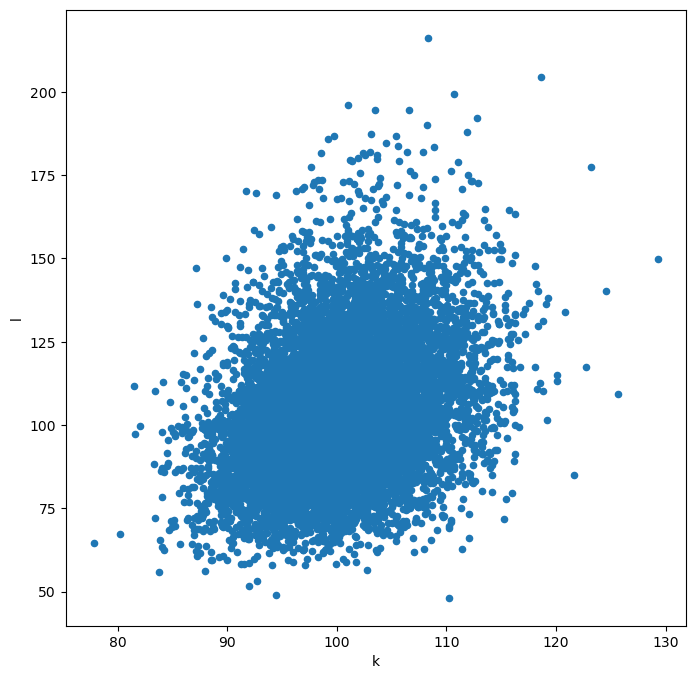

In [146]:
pd.DataFrame({
    "k": gbm_gen.get_path(0, "S").detach().cpu().numpy(),
    "l": gbm_gen.get_path(10, "S").detach().cpu().numpy(),
    "init": S_prev    .detach().cpu().numpy()
}).plot.scatter(x="k", y="l", figsize=(8,8))

In [93]:


class CashFlowGenerator:
    def __init__(self, path_gen: PathGenerator, fin_prod: FinancialProduct):
        self.path_gen = path_gen
        self.fin_prod = fin_prod
        

    def yield_cashflow(self, step: Int, name: str):
        X = self.path_gen.get_path(step, name)
        self.fin_prod.payoff_fn(X)

        





NameError: name 'Int' is not defined